acousticness - A confidence measure from 0.0 to 1.0 of whether the track is acoustic. 1.0 represents high confidence the track is acoustic.
<p/>
danceability - Danceability describes how suitable a track is for dancing based on a combination of musical elements including tempo, rhythm stability, beat strength, and overall regularity. A value of 0.0 is least danceable and 1.0 is most danceable.
<p/>
energy - Energy is a measure from 0.0 to 1.0 and represents a perceptual measure of intensity and activity. Typically, energetic tracks feel fast, loud, and noisy. For example, death metal has high energy, while a Bach prelude scores low on the scale. Perceptual features contributing to this attribute include dynamic range, perceived loudness, timbre, onset rate, and general entropy.
<p/>
instrumentalness - Predicts whether a track contains no vocals. “Ooh” and “aah” sounds are treated as instrumental in this context. Rap or spoken word tracks are clearly “vocal”. The closer the instrumentalness value is to 1.0, the greater likelihood the track contains no vocal content. Values above 0.5 are intended to represent instrumental tracks, but confidence is higher as the value approaches 1.0.
<p/>
liveness - Detects the presence of an audience in the recording. Higher liveness values represent an increased probability that the track was performed live. A value above 0.8 provides strong likelihood that the track is live.
<p/>
loudness - The overall loudness of a track in decibels (dB). Loudness values are averaged across the entire track and are useful for comparing relative loudness of tracks. Loudness is the quality of a sound that is the primary psychological correlate of physical strength (amplitude). Values typical range between -60 and 0 db.
<p/>
speechiness - Speechiness detects the presence of spoken words in a track. The more exclusively speech-like the recording (e.g. talk show, audio book, poetry), the closer to 1.0 the attribute value. Values above 0.66 describe tracks that are probably made entirely of spoken words. Values between 0.33 and 0.66 describe tracks that may contain both music and speech, either in sections or layered, including such cases as rap music. Values below 0.33 most likely represent music and other non-speech-like tracks.
<p/>
valence - A measure from 0.0 to 1.0 describing the musical positiveness conveyed by a track. Tracks with high valence sound more positive (e.g. happy, cheerful, euphoric), while tracks with low valence sound more negative (e.g. sad, depressed, angry)
<p/>
Mode indicates the modality (major or minor) of a track, the type of scale from which its melodic content is derived. Major is represented by 1 and minor is 0.

In [1]:
import pandas as pd
import numpy as np
import datetime
from math import pi

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.cluster import KMeans
from scipy.spatial.distance import cdist
from sklearn import metrics

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

datapath = '../Data/'

# Import data

In [2]:
def load_playlist(playlist='saved_tracks.h5'):
    '''
    Takes in the path of the data.
    Reads the data, convertes added_at to a datetime object and extract year and month to new column.
    Also standardise the tempo to between 0 and 1.
    Returns a dataframe.
    '''
    
#     read data
    df_playlist = pd.read_hdf(datapath + playlist, key='df')
    df_playlist.drop(['analysis_url', 'track_href', 'uri', 'type'], axis=1, inplace=True)
    
#     convert to datetime, extrated year and month from added_at
    df_playlist['added_at'] = df_playlist['added_at'].apply(lambda x : datetime.datetime.strptime(x,"%Y-%m-%dT%H:%M:%SZ"))
    df_playlist['added_year'] = df_playlist['added_at'].apply(lambda x : x.year)
    df_playlist['added_month'] = df_playlist['added_at'].apply(lambda x : x.month)
    
#     standardise tempo to be between 0 and 1
    df_playlist['tempo_01'] = df_playlist['tempo'] / df_playlist['tempo'].max()
    return df_playlist

In [3]:
df_saved = load_playlist()
print(df_saved.shape)

(446, 20)


In [4]:
df_saved.sample(5)

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,added_at,song_title,artists,added_year,added_month,tempo_01
1,0.208,0.806,214827,0.843,4E92TMtPQAN73sQ6UaBvsy,0.00105,10,0.226,-6.861,0,0.0378,108.910,4,0.909,2016-11-02 15:01:09,A Night to Remember,Shalamar,2016,11,0.538884
19,0.153,0.831,239227,0.921,4jnFqNWeJCeCRHc4HCdxfd,0.00213,5,0.305,-2.383,0,0.0581,108.002,4,0.794,2018-03-06 03:27:36,Remember the Time,Michael Jackson,2018,3,0.534391
14,0.499,0.619,194019,0.574,1L9X1uzSZoPwyVzFOIOKDh,0.00000,7,0.125,-4.925,1,0.0286,85.843,4,0.383,2018-04-01 05:59:16,Good For You,Eric Nam,2018,4,0.424749
15,0.066,0.834,213333,0.762,79WoTVS0xrTPNboNtTRpxW,0.00000,5,0.306,-6.525,0,0.1170,108.095,4,0.896,2016-04-13 14:01:49,What's Your Flava? - Radio Edit,Craig David,2016,4,0.534851
9,0.414,0.748,244960,0.524,7BKLCZ1jbUBVqRi2FVlTVw,0.00000,8,0.111,-5.599,1,0.0338,95.010,4,0.661,2016-08-27 01:22:04,Closer,"The Chainsmokers,Halsey",2016,8,0.470107


# Finding out changes in taste and preferences

In [5]:
# Filter data to songs added after 2014
df_grp_ym = df_saved.groupby(['added_year','added_month']).mean().reset_index()
df_grp_ym = df_grp_ym[df_grp_ym['added_year'] > 2014]
df_grp_ym['added_at'] = df_grp_ym.apply(lambda row: datetime.date(int(row['added_year']), int(row['added_month']), 1), axis=1)
df_grp_ym.head()

,added_year,added_month,acousticness,danceability,duration_ms,energy,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,tempo_01,added_at
3,2015,1,0.021433,0.643250,229706.750000,0.742000,0.001026,4.000000,0.131600,-5.847000,1.000000,0.068900,119.491250,4.0,0.628000,0.591239,2015-01-01
4,2015,2,0.343633,0.574000,202339.333333,0.575000,0.000022,7.666667,0.141200,-7.214667,0.333333,0.041833,108.213333,4.0,0.494333,0.535437,2015-02-01
5,2015,4,0.348386,0.524857,227214.142857,0.636857,0.032892,6.857143,0.121800,-6.747429,1.000000,0.037700,121.472429,4.0,0.286714,0.601042,2015-04-01
6,2015,5,0.373795,0.571000,206272.000000,0.557500,0.000000,0.000000,0.132800,-7.135500,1.000000,0.030600,134.428000,4.0,0.400500,0.665146,2015-05-01
7,2015,6,0.159285,0.615500,234052.875000,0.744375,0.003026,2.875000,0.292625,-4.877250,0.625000,0.075413,107.985750,4.0,0.456737,0.534310,2015-06-01


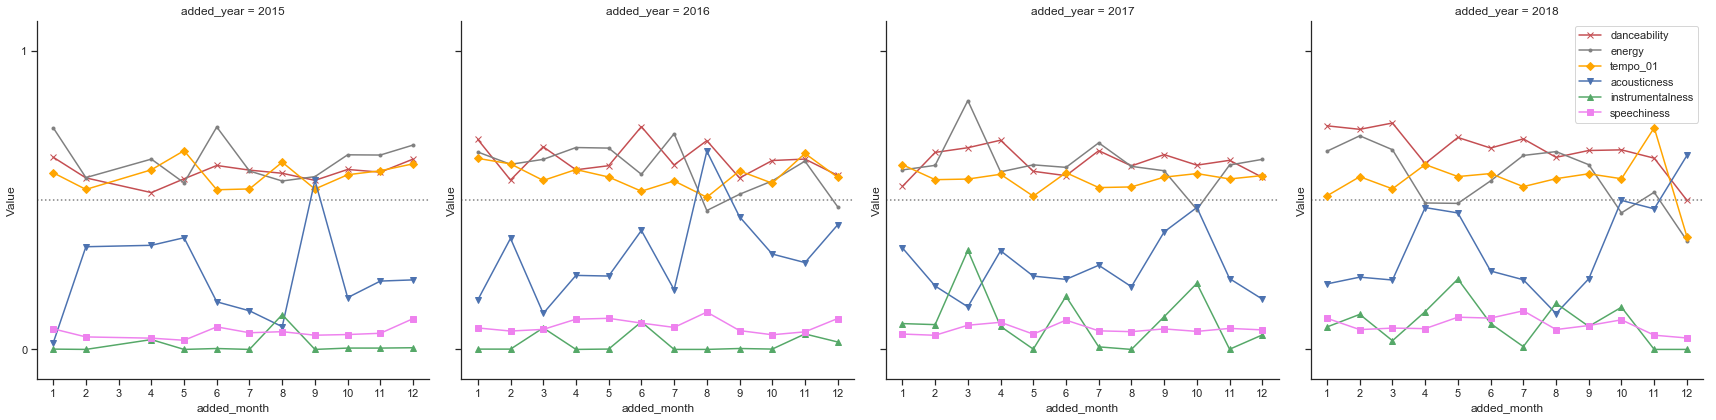

In [6]:
sns.set(style="ticks")
grid = sns.FacetGrid(data=df_grp_ym, col="added_year", height=6)

# Draw a horizontal line to show the starting point
grid.map(plt.axhline, y=0.5, ls=":", c=".5")

# Draw a line plot to show the average value per month
grid.map(plt.plot, "added_month", "danceability", marker="x", color='r', label='danceability')
grid.map(plt.plot, "added_month", "energy", marker=".", color='grey', label='energy')
grid.map(plt.plot, "added_month", "tempo_01", marker="D", color='orange', label='tempo_01')

grid.map(plt.plot, "added_month", "acousticness", marker="v", color='b', label='acousticness')
grid.map(plt.plot, "added_month", "instrumentalness", marker="^", color='g', label='instrumentalness')
grid.map(plt.plot, "added_month", "speechiness", marker="s", color='violet', label='speechiness')


# Adjust the tick positions and labels
grid.set(xticks=np.arange(13), yticks=[0, 1], 
         xlim=(0.5,12.5), ylim=(-0.1,1.1), 
         ylabel='Value')

# Adjust the arrangement of the plots
grid.fig.tight_layout(w_pad=1)

plt.legend()

plt.show()

# Filtering out to recent songs based on taste and preferences

In [7]:
df_recent = df_saved[df_saved['added_year'] >= 2017]

In [8]:
df_recent.sample(5)

,acousticness,danceability,duration_ms,energy,id,instrumentalness,key,liveness,loudness,mode,speechiness,tempo,time_signature,valence,added_at,song_title,artists,added_year,added_month,tempo_01
12,0.4210,0.831,204760,0.657,4RcttSz7uRL9O2NyuFKaW2,0.000,11,0.132,-4.161,0,0.0483,105.001,4,0.916,2017-12-21 14:39:32,Oops,"Little Mix,Charlie Puth",2017,12,0.519542
11,0.2170,0.829,262698,0.748,3Of77FYMTeIucSWOnOvAkH,0.000,1,0.204,-3.614,1,0.1240,90.013,4,0.324,2018-07-27 07:46:17,Pep Rally,Missy Elliott,2018,7,0.445382
10,0.0485,0.746,174933,0.846,3R6dPfF2yBO8mHySW1XDAa,0.000,9,0.195,-2.432,1,0.0480,114.955,4,0.403,2018-07-27 07:49:11,Solo Dance,Martin Jensen,2018,7,0.568794
5,0.0323,0.671,209355,0.859,7b8YOVV5quZcSKEijDgyWB,0.000,4,0.267,-3.922,0,0.0833,139.931,4,0.389,2018-08-04 04:30:04,DDU-DU DDU-DU,BLACKPINK,2018,8,0.692375
9,0.7690,0.716,199079,0.409,1SmG7OvvBIPFprdKI8ENHD,0.173,0,0.108,-10.943,1,0.0636,92.041,4,0.162,2018-10-03 10:31:42,Find a Way,"Matt Quentin,Rinca Yang",2018,10,0.455416


# Clustering similar songs together

In [9]:
cluster_features = ['acousticness', 'danceability', 'instrumentalness', 'energy', 'speechiness','tempo_01']
df_cluster = df_recent[cluster_features]
X = np.array(df_cluster)

In [10]:
# from sklearn.preprocessing import StandardScaler
# scaler = StandardScaler()
# scaler.fit(X)
# X = scaler.transform(X)

In [11]:
distortions = []
K = range(2,10)
for k in K:
    kmeanModel = KMeans(n_clusters=k, max_iter=1000, init='k-means++', random_state=123).fit(X)
    kmeanModel.fit(X)
    distortions.append(sum(np.min(cdist(X, kmeanModel.cluster_centers_, 'euclidean'), axis=1)) / X.shape[0])


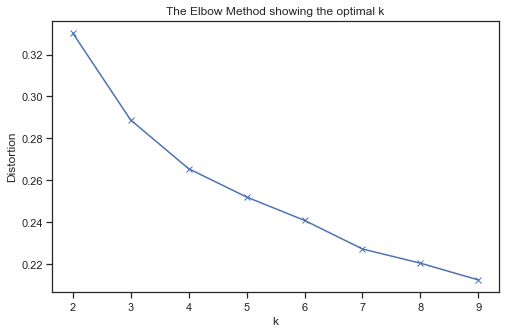

In [12]:
# Plot the elbow
plt.figure(figsize=(8,5))
plt.plot(K, distortions, 'bx-')
plt.xlabel('k')
plt.ylabel('Distortion')
plt.title('The Elbow Method showing the optimal k')
plt.show()

In [33]:
num_clusters = 4
kmeanModel = KMeans(n_clusters=num_clusters, max_iter=1000, init='k-means++', random_state=123).fit(X)

# Visualisation of cluster using PCA

In [61]:
pca = PCA(n_components=2, random_state=123)
pca_results = pca.fit_transform(X)

In [62]:
pca.explained_variance_ratio_.sum()

0.7318243252426813

In [63]:
df_pca = pd.DataFrame(pca_results)
df_pca.columns = ['PC1', 'PC2']
df_pca['label'] = kmeanModel.labels_
df_pca.head()

,PC1,PC2,label
0,0.432765,-0.188869,1
1,0.347532,-0.158665,1
2,-0.029414,-0.065897,2
3,0.682007,-0.226529,1
4,-0.114495,-0.058194,2


In [64]:
# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = Axes3D(fig)

# ax.scatter(df_pca['PC1'], df_pca['PC2'], df_pca['PC3'],
#            c=df_pca['label'], cmap='Set1')

# ax.set_xlabel('PC1')
# ax.set_ylabel('PC2')
# ax.set_zlabel('PC3')
# plt.show()

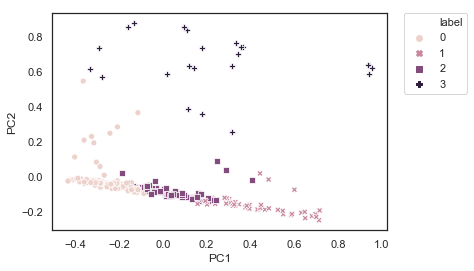

In [65]:
sns.set_style('white')
sns.scatterplot(data=df_pca, x='PC1', y='PC2', hue='label', style='label')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

# Visualisation of clusters using TSNE

In [94]:
tsne = TSNE(n_components=2, perplexity=30, n_iter=5000, random_state=123)
tsne_results = tsne.fit_transform(X)

In [95]:
df_tsne = pd.DataFrame(tsne_results)
df_tsne.columns = ['D1', 'D2']
df_tsne['label'] = kmeanModel.labels_
df_tsne.head()

,D1,D2,label
0,6.574992,-13.591134,1
1,11.262351,-12.603945,1
2,8.762847,-0.467893,2
3,9.722727,-15.624294,1
4,4.465741,-1.238261,2


In [96]:
# from matplotlib import pyplot as plt
# from mpl_toolkits.mplot3d import Axes3D

# fig = plt.figure()
# ax = Axes3D(fig)

# ax.scatter(df_tsne['D1'], df_tsne['D2'], df_tsne['D3'],
#            c=df_tsne['label'], cmap='Set1')

# ax.set_xlabel('D1')
# ax.set_ylabel('D2')
# ax.set_zlabel('D3')
# plt.show()

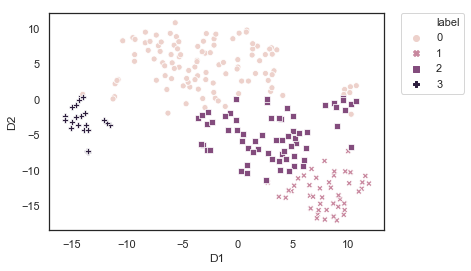

In [97]:
sns.set_style('white')
sns.scatterplot(data=df_tsne, x='D1', y='D2', hue='label', style='label')
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
plt.show()

In [103]:
df_recent.groupby('cluster').size().reset_index(name='Num of songs')

,cluster,Num of songs
0,0,106
1,1,45
2,2,65
3,3,23


# Average song features per cluster

In [98]:
# assign label to recent dataframe
df_recent.loc[:,'cluster'] = kmeanModel.labels_

# calculate mean of each variable
radar_col = cluster_features + ['cluster']

df_radar = df_recent[radar_col]
df_radar = df_radar.groupby('cluster').mean().reset_index()
df_radar

C:\Users\john_koh\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


,cluster,acousticness,danceability,instrumentalness,energy,speechiness,tempo_01
0,0,0.108303,0.705481,0.025484,0.772462,0.077287,0.580061
1,1,0.673133,0.504067,0.014199,0.400933,0.057244,0.550573
2,2,0.315771,0.693585,0.008527,0.501323,0.100103,0.561617
3,3,0.374790,0.644261,0.774913,0.514565,0.061096,0.598143


In [99]:
# https://python-graph-gallery.com/392-use-faceting-for-radar-chart/
def make_radar(row, title, color, dframe):
    # number of variable
    categories=list(dframe)[1:]
    N = len(categories)
    
    # What will be the angle of each axis in the plot? (we divide the plot / number of variable)
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]
    
    # Initialise the radar plot
    ax = plt.subplot(3,2,row+1, polar=True, )
    
    # If you want the first axis to be on top:
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)

    # Draw one axe per variable + add labels labels yet
    plt.xticks(angles[:-1], categories, color='grey', size=8)

    # Draw ylabels
    ax.set_rlabel_position(0)
    plt.yticks([0.2,0.4,0.6,0.8], ["0.2","0.4","0.6","0.8"], color="grey", size=7)
    plt.ylim(0,1)

    # Ind1
    values=dframe.loc[row].drop('cluster').values.flatten().tolist()
    values += values[:1]
    ax.plot(angles, values, color=color, linewidth=2, linestyle='solid')
    ax.fill(angles, values, color=color, alpha=0.4)

    # Add a title
    plt.title(title, size=8, color=color, y=1.06)

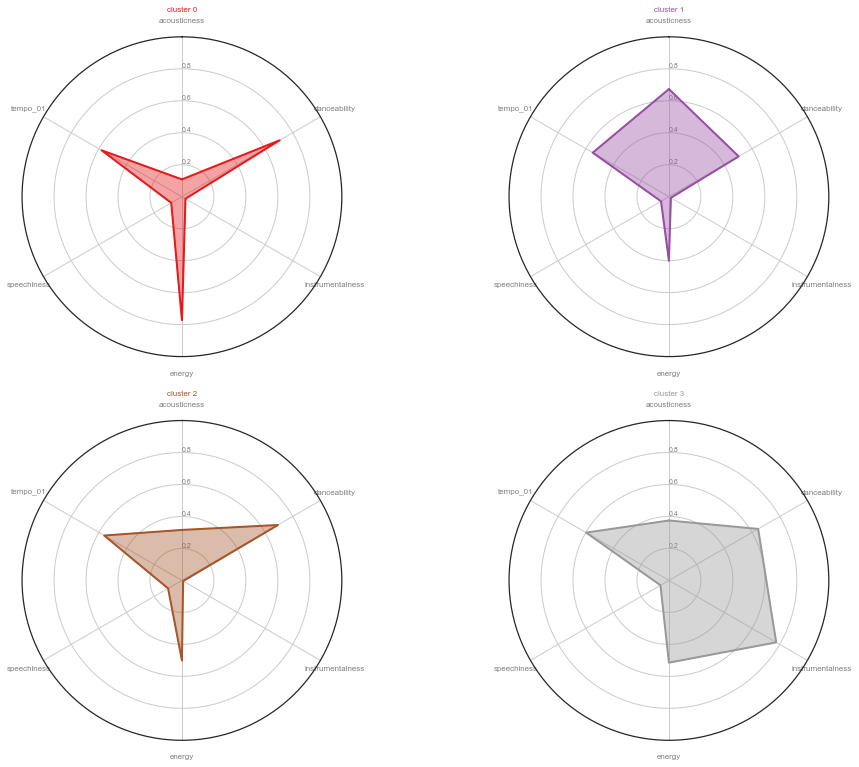

In [100]:
# initialize the figure
plt.figure(figsize=(16,20))
 
# Create a color palette:
my_palette = plt.cm.get_cmap("Set1", len(df_radar.index))
 
# Loop to plot
for row in range(0, len(df_radar.index)):
    make_radar(row=row, title='cluster '+ str(df_radar['cluster'][row]), color=my_palette(row), dframe=df_radar)

# Song feature distribution compared to overall distribution

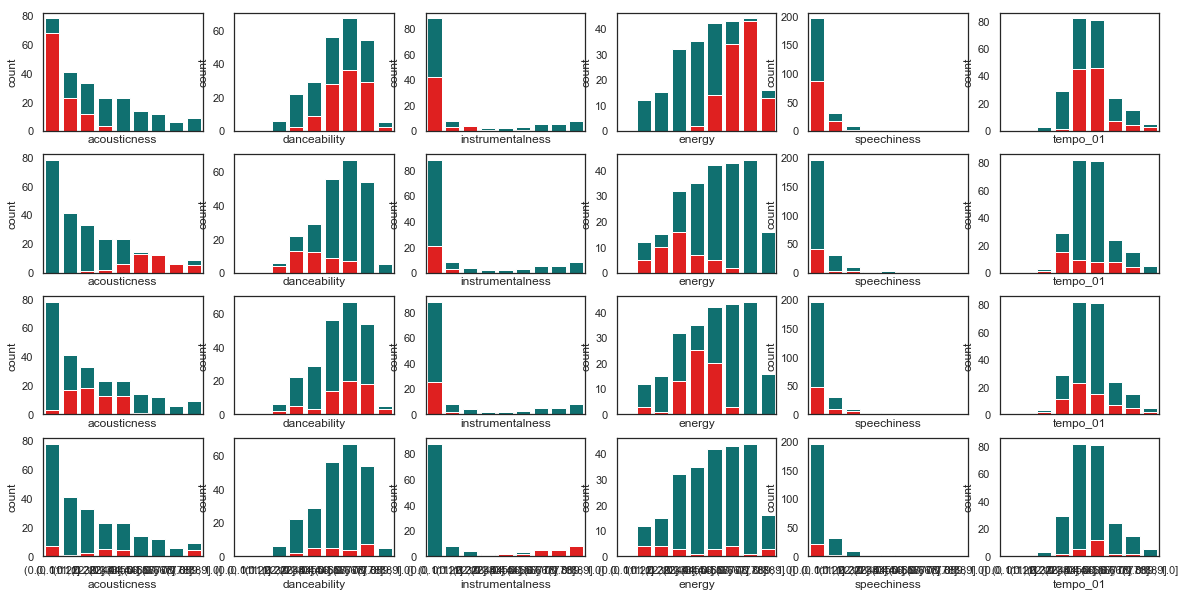

In [107]:
# set binning intervals of 0.1
bins = np.linspace(0,1,10)

# plot
f, axes = plt.subplots(num_clusters, 6, figsize=(20, 10), sharex='col')
# initialise 1st row. Representing cluster
row = 0

for cluster in np.sort(df_recent['cluster'].unique()):
#     filter cluster dataframe and reset column to 0 for 1st plot for the cluster
    df_cluster = df_recent[df_recent['cluster'] == cluster]
    col = 0
    
    for feature in cluster_features:
#         create binned count for all recent df and clustered df
        rec_grp = df_recent.groupby(pd.cut(df_recent[feature], bins)).size().reset_index(name='count')
        cluster_grp = df_cluster.groupby(pd.cut(df_cluster[feature], bins)).size().reset_index(name='count')
        
#         plot overall distribution and cluster distribution on the ax
        sns.barplot(data=rec_grp, x=feature, y='count', color='teal', ax=axes[row, col])
        sns.barplot(data=cluster_grp, x=feature, y='count', color='red', ax=axes[row, col])
        
        col += 1
    row += 1

    
plt.show()

# Sampling of songs in cluster

In [105]:
cluster_num = 0
df_cluster = df_recent[df_recent['cluster'] == cluster_num]
df_cluster[['song_title', 'artists']].sample(5)

,song_title,artists
16,공허해 empty,WINNER
4,Jusagroove,CHIC
9,2 U (feat. Anthony Pavel),"Pink Slip,Anthony Pavel"
18,Deep Down,Zhavia Ward
15,Over My Head (Cable Car),The Fray
